In [1]:
pip install pandas numpy matplotlib tensorflow scikit-learn


<ipython-input-3-26a5c0ba60d2>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_positive = df['positive'].resample('M').sum()


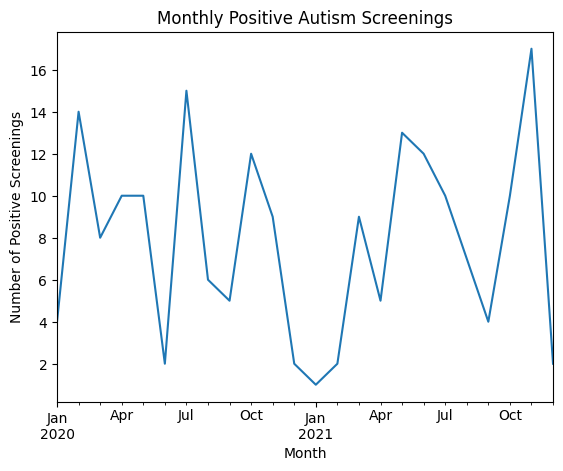

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1894 - val_loss: 0.3474
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step - loss: 0.1620 - val_loss: 0.3034
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1370 - val_loss: 0.2608
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1150 - val_loss: 0.2200
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0971 - val_loss: 0.1827
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.0855 - val_loss: 0.1515
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0827 - val_loss: 0.1307
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0889 - val_loss: 0.1216
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.0966 - val_loss: 0.1196
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.0985 - val_loss: 0.1215
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0950 - val_loss: 0.1265
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0895 - val_loss:

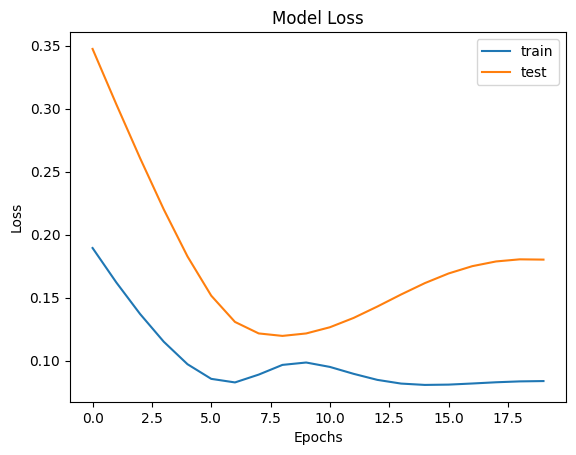

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


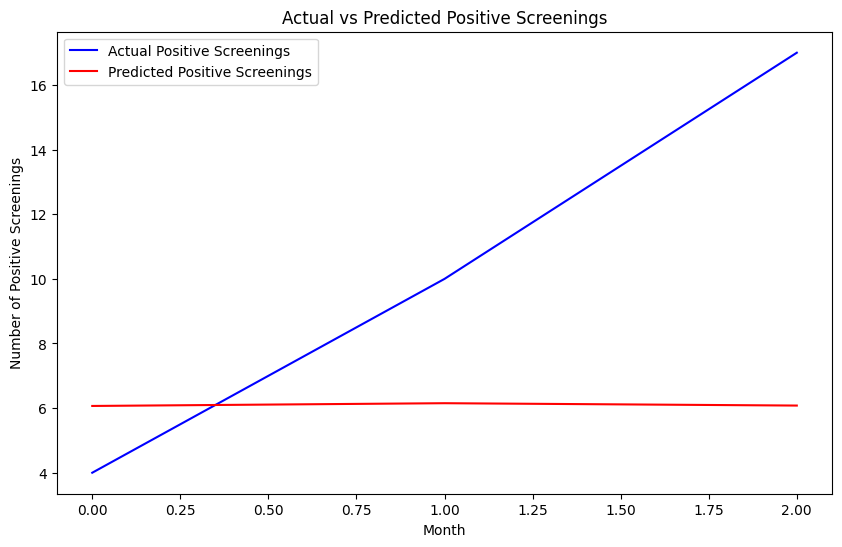

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# Step 1: Load the dataset (replace with your actual dataset)
df = pd.read_csv("autism_screening.csv")  # Replace with your actual dataset path

# Step 2: Create a synthetic date column (if not present)
df['date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
df.set_index('date', inplace=True)

# Step 3: Create a binary column for positive autism screening (Class/ASD == YES)
df['positive'] = df['Class/ASD'].apply(lambda x: 1 if x == 'YES' else 0)

# Step 4: Aggregate the data to monthly counts of positive autism screenings
monthly_positive = df['positive'].resample('M').sum()

# Step 5: Visualize the data
monthly_positive.plot(title="Monthly Positive Autism Screenings")
plt.xlabel("Month")
plt.ylabel("Number of Positive Screenings")
plt.show()

# Step 6: Prepare the data for LSTM (Normalization and Time Series Creation)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_positive.values.reshape(-1, 1))

# Step 7: Create a function to prepare time steps
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Step 8: Create the dataset with time step 12 (for 1 year of data)
time_step = 12
X, y = create_dataset(scaled_data, time_step)

# Step 9: Reshape X to be suitable for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 10: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 11: Build the LSTM model04

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

# Step 12: Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 13: Plot training & validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 14: Make predictions on the test set
predictions = model.predict(X_test)

# Step 15: Inverse scale predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 16: Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label="Actual Positive Screenings")
plt.plot(predictions, color='red', label="Predicted Positive Screenings")
plt.title("Actual vs Predicted Positive Screenings")
plt.xlabel("Month")
plt.ylabel("Number of Positive Screenings")
plt.legend()
plt.show()
